<a href="https://colab.research.google.com/github/magicv711/ERP-Ball-Mapper-Analysis-of-Structural-Dynamics-in-the-UK-Housing-Market/blob/main/ERP_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyballmapper
!pip install kmapper

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.8/126.8 kB 2.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyballmapper as pbm
import statistics
import seaborn as sb
import statsmodels.api as sm
import networkx as nx
from sklearn.preprocessing import StandardScaler
# Then the additional code for colouring the TDABM plots

from matplotlib.colors import ListedColormap
from matplotlib import colormaps as cm

# Define the colouration scheme

hsvp = cm.get_cmap("gist_rainbow")

# The specific code for the Variance Inflation Factor (VIF)

from statsmodels.stats.outliers_influence import variance_inflation_factor
from pyballmapper import BallMapper as bm

from statsmodels.stats.outliers_influence import variance_inflation_factor

#模拟

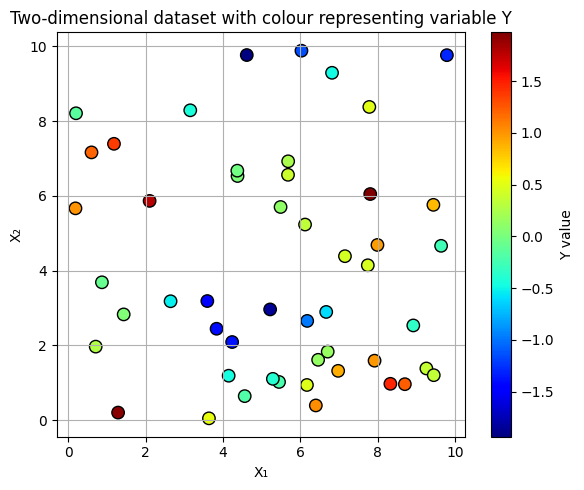

In [ ]:

# 生成模拟数据
np.random.seed(0)
x1 = np.random.uniform(0, 10, 50)
x2 = np.random.uniform(0, 10, 50)
y = np.sin(x1) + np.cos(x2)  # 模拟第三变量（可替换成房价等）

# 绘图
plt.figure(figsize=(6, 5))
scatter = plt.scatter(x1, x2, c=y, cmap='jet', s=80, edgecolor='k')
plt.xlabel("X₁")
plt.ylabel("X₂")
cbar = plt.colorbar(scatter)
cbar.set_label("Y value")
plt.title("Two-dimensional dataset with colour representing variable Y")
plt.grid(True)
plt.tight_layout()
plt.show()


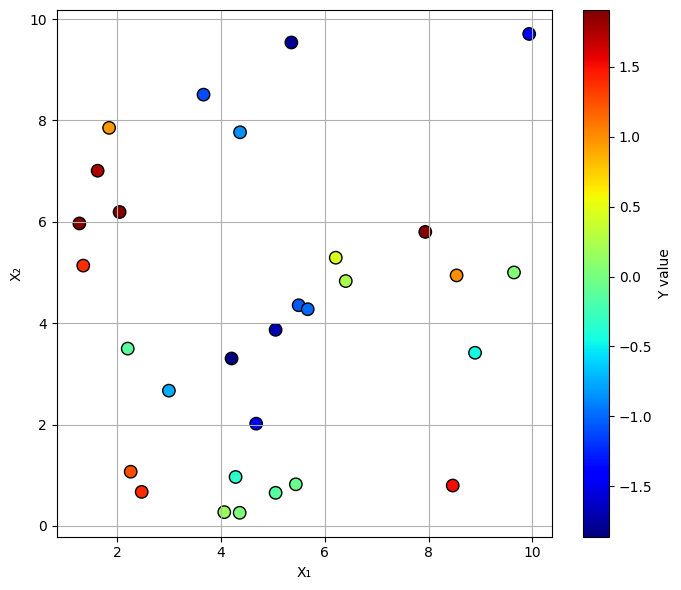

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 使用与 Ball Mapper 相同的数据
np.random.seed(2)
X = np.random.uniform(0, 10, size=(30, 2))
y = np.sin(X[:, 0]) + np.cos(X[:, 1])  # 用作颜色

# 绘制无 landmark 的原始数据图
fig, ax = plt.subplots(figsize=(7, 6))
sc = ax.scatter(X[:, 0], X[:, 1], c=y, cmap='jet', s=80, edgecolor='k')
plt.colorbar(sc, ax=ax, label='Y value')
ax.set_xlabel('X₁')
ax.set_ylabel('X₂')

plt.grid(True)
plt.tight_layout()
plt.show()

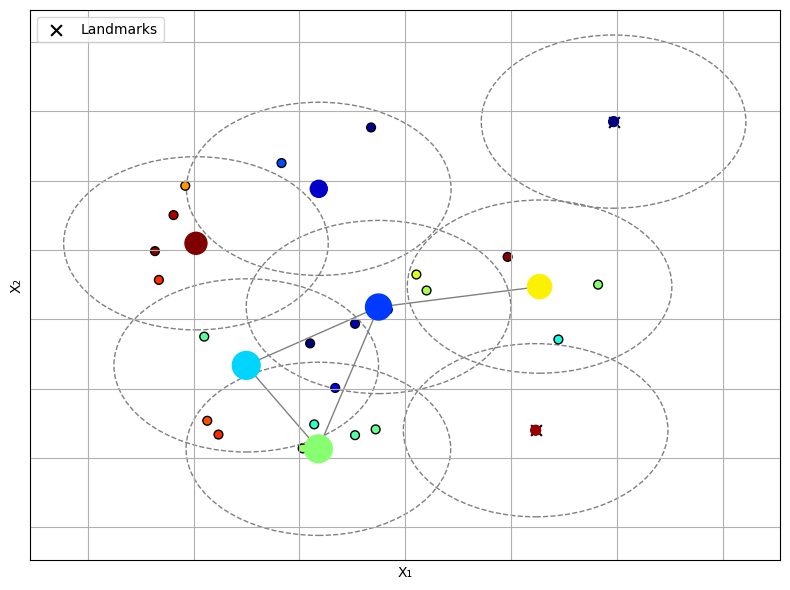

In [ ]:
# Re-run after kernel reset
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import networkx as nx
from scipy.spatial.distance import cdist

# 生成模拟二维数据
np.random.seed(2)
X = np.random.uniform(0, 10, size=(30, 2))
y = np.sin(X[:, 0]) + np.cos(X[:, 1])  # 用作颜色

# 设定球半径
epsilon = 2.5

# Max-min ε-net 中选取 landmark（简单实现）
landmarks = [X[0]]
for point in X:
    if np.min(np.linalg.norm(point - np.array(landmarks), axis=1)) > epsilon:
        landmarks.append(point)
landmarks = np.array(landmarks)

# 计算每个 landmark 的覆盖点
balls = {}
for i, lm in enumerate(landmarks):
    balls[i] = np.where(np.linalg.norm(X - lm, axis=1) <= epsilon)[0]

# 构建 BM 图结构
G = nx.Graph()
for i in balls:
    G.add_node(i, pos=landmarks[i], size=len(balls[i]), color=np.mean(y[balls[i]]))
    for j in balls:
        if i < j and len(set(balls[i]) & set(balls[j])) > 0:
            G.add_edge(i, j)

# 绘图
fig, ax = plt.subplots(figsize=(8, 6))

# 画圆表示球覆盖
for i, center in enumerate(landmarks):
    circle = Circle(center, epsilon, edgecolor='gray', facecolor='none', linestyle='--', linewidth=1)
    ax.add_patch(circle)

# 原始点着色
sc = ax.scatter(X[:, 0], X[:, 1], c=y, cmap='jet', s=40, edgecolor='k')

# Landmark 点
ax.scatter(landmarks[:, 0], landmarks[:, 1], c='black', s=60, marker='x', label='Landmarks')

# 画图节点与连线
pos = {i: (landmarks[i][0], landmarks[i][1]) for i in G.nodes}
colors = [G.nodes[i]['color'] for i in G.nodes]
sizes = [G.nodes[i]['size'] * 50 for i in G.nodes]
nx.draw_networkx_nodes(G, pos, node_color=colors, cmap='jet', node_size=sizes, ax=ax)
nx.draw_networkx_edges(G, pos, edge_color='gray', width=1, ax=ax)

# 格式设置

ax.set_xlabel('X₁')
ax.set_ylabel('X₂')

ax.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
def prepare_event_driven_price_diff(df_price_raw):
    # 日期处理
    df_price = df_price_raw.copy()
    df_price["Date"] = pd.to_datetime(df_price["Date"], dayfirst=True, errors="coerce")
    df_price = df_price[df_price["Date"].notna()]

    # 仅保留核心字段
    df_price = df_price[["Date", "RegionName", "AreaCode", "AveragePrice"]]

    # 设定三个事件窗口：元组格式 (start_date, end_date)
    event_windows = {
        "Crisis_0809": ("2008-06-01", "2009-03-01"),
        "Stable_1516": ("2015-06-01", "2016-03-01"),
        "Covid_2020":  ("2020-02-01", "2020-11-01"),
    }

    # 存储每个事件的 price diff
    diff_dfs = []

    for event, (start_date, end_date) in event_windows.items():
        # 筛选两个月份数据
        df_start = df_price[df_price["Date"] == pd.to_datetime(start_date)]
        df_end = df_price[df_price["Date"] == pd.to_datetime(end_date)]

        # 重命名
        df_start = df_start.rename(columns={"AveragePrice": "Price_Start"})
        df_end = df_end.rename(columns={"AveragePrice": "Price_End"})

        # 合并并计算差值
        df_diff = pd.merge(df_start, df_end, on=["RegionName", "AreaCode"], how="inner")
        df_diff[f"{event}_Diff"] = df_diff["Price_End"] - df_diff["Price_Start"]

        # 只保留结果和标识
        df_diff = df_diff[["RegionName", "AreaCode", f"{event}_Diff"]]
        diff_dfs.append(df_diff)

    # 合并所有事件差值为一个表
    from functools import reduce
    df_merged_diff = reduce(lambda left, right: pd.merge(left, right, on=["RegionName", "AreaCode"], how="outer"), diff_dfs)

    return df_merged_diff


In [ ]:
df_price_raw = pd.read_csv("/content/house price data.csv")
df_price_diff = prepare_event_driven_price_diff(df_price_raw)

In [ ]:
df_price_diff

,RegionName,AreaCode,Crisis_0809_Diff,Stable_1516_Diff,Covid_2020_Diff
0,Aberdeenshire,S12000034,-13628,-2218,7645
1,Adur,E07000223,-43101,24208,20401
2,Amber Valley,E07000032,-17691,2616,12667
3,Angus,S12000041,-20767,-274,12655
4,Antrim and Newtownabbey,N09000001,-48088,983,4830
...,...,...,...,...,...
400,Wychavon,E07000238,-23894,15479,9709
401,Wyre,E07000128,-19713,817,1866
402,Wyre Forest,E07000239,-20606,7103,1445
403,York,E06000014,-25242,13341,10448


In [ ]:
year_data = pd.read_csv('/content/year_data_cleaned.csv')
year_data = year_data.rename(columns={"RegionName_x": "RegionName"})
year_data = year_data.drop(columns=["RegionName_y"], errors='ignore')

# 与年度数据合并
year_data_enriched = pd.merge(
    year_data,
    df_price_diff,
    on=["RegionName", "AreaCode"],
    how="left"
)

In [ ]:
data_bm=year_data_enriched

In [ ]:
data_bm.to_csv('data_bm.csv', index=False)

#code


In [ ]:
df = pd.read_csv('/content/data_bm.csv')

In [ ]:
df

,RegionName,AreaCode,Year,AveragePrice,1m%Change,12m%Change,SalesVolume,SemiDetachedPrice,NewPrice,OldPrice,...,UnemploymentRate_16_64,UnemploymentRate_16plus,Inactive_WantJob,Inactive_NoJob,Population,TotalArea,PeoplePerSqKm,Crisis_0809_Diff,Stable_1516_Diff,Covid_2020_Diff
0,Aberdeenshire,S12000034,2007,167845.2,1.8,27.6,516.7,145561.5,218891.5,161613.5,...,2.1,2,23,77,NaN,NaN,NaN,-13628,-2218,7645
1,Aberdeenshire,S12000034,2008,179441.2,0.1,7.5,383.3,157182.4,236504.0,172388.3,...,2.7,2.7,33.2,66.8,NaN,NaN,NaN,-13628,-2218,7645
2,Aberdeenshire,S12000034,2014,199781.1,0.7,7.6,486.0,174790.7,269926.8,191773.1,...,4,3.9,28.7,71.3,NaN,NaN,NaN,-13628,-2218,7645
3,Aberdeenshire,S12000034,2015,207355.6,-0.1,4.0,424.8,181954.9,279709.8,199095.9,...,2.4,2.3,35.8,64.2,NaN,NaN,NaN,-13628,-2218,7645
4,Aberdeenshire,S12000034,2019,190988.8,-0.2,-2.5,339.8,168766.4,267031.5,182920.0,...,2.7,2.7,23,77,NaN,NaN,NaN,-13628,-2218,7645
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2071,York,E06000014,2008,183766.2,-1.2,-5.0,189.0,188301.8,196204.0,182342.5,...,4.2,4.1,13.5,86.5,716.527514,271.98816,2.634407,-25242,13341,10448
2072,York,E06000014,2014,199576.1,0.6,6.7,313.5,206556.7,211568.8,198679.1,...,4.1,4,20.6,79.4,202206.000000,271.93580,743.579918,-25242,13341,10448
2073,York,E06000014,2015,214080.6,0.5,7.3,294.3,221795.5,228076.8,212991.0,...,4.3,4.3,23.7,76.3,203212.000000,271.93580,747.279321,-25242,13341,10448
2074,York,E06000014,2019,248339.8,0.0,2.6,270.0,260652.6,272745.3,247236.1,...,2.6,2.6,14.2,85.8,203877.000000,271.93580,749.724751,-25242,13341,10448


In [ ]:
df.columns

Index(['RegionName', 'AreaCode', 'Year', 'AveragePrice', '1m%Change',
       '12m%Change', 'SalesVolume', 'SemiDetachedPrice', 'NewPrice',
       'OldPrice', 'Income', 'EconActiveRate_16_64', 'EmploymentRate_16_64',
       'Employees_16_64', 'SelfEmployed_16_64', 'UnemploymentRate_16_64',
       'UnemploymentRate_16plus', 'Inactive_WantJob', 'Inactive_NoJob',
       'Population', 'TotalArea', 'PeoplePerSqKm', 'Crisis_0809_Diff',
       'Stable_1516_Diff', 'Covid_2020_Diff'],
      dtype='object')

In [ ]:
house_data = ['RegionName', 'AreaCode', 'Year', 'AveragePrice', '1m%Change',
       '12m%Change', 'SalesVolume', 'SemiDetachedPrice', 'NewPrice',
       'OldPrice']
df[house_data]

,RegionName,AreaCode,Year,AveragePrice,1m%Change,12m%Change,SalesVolume,SemiDetachedPrice,NewPrice,OldPrice
0,Aberdeenshire,S12000034,2007,167845.2,1.8,27.6,516.7,145561.5,218891.5,161613.5
1,Aberdeenshire,S12000034,2008,179441.2,0.1,7.5,383.3,157182.4,236504.0,172388.3
2,Aberdeenshire,S12000034,2014,199781.1,0.7,7.6,486.0,174790.7,269926.8,191773.1
3,Aberdeenshire,S12000034,2015,207355.6,-0.1,4.0,424.8,181954.9,279709.8,199095.9
4,Aberdeenshire,S12000034,2019,190988.8,-0.2,-2.5,339.8,168766.4,267031.5,182920.0
...,...,...,...,...,...,...,...,...,...,...
2071,York,E06000014,2008,183766.2,-1.2,-5.0,189.0,188301.8,196204.0,182342.5
2072,York,E06000014,2014,199576.1,0.6,6.7,313.5,206556.7,211568.8,198679.1
2073,York,E06000014,2015,214080.6,0.5,7.3,294.3,221795.5,228076.8,212991.0
2074,York,E06000014,2019,248339.8,0.0,2.6,270.0,260652.6,272745.3,247236.1


In [ ]:
#'1m%Change', '12m%Change','SemiDetachedPrice', 'NewPrice', 'OldPrice','NewPrice', 'OldPrice',

In [ ]:
df[[
    'RegionName', 'AreaCode', 'Year','AveragePrice',  'SalesVolume','1m%Change','OldPrice',
    'Income',
    'EmploymentRate_16_64', 'SelfEmployed_16_64',
    'Inactive_WantJob',
    'Population', 'PeoplePerSqKm'

]].isnull().sum()

,0
RegionName,0
AreaCode,0
Year,0
AveragePrice,0
SalesVolume,0
1m%Change,0
OldPrice,0
Income,0
EmploymentRate_16_64,0
SelfEmployed_16_64,0


In [ ]:
features = [
    'AveragePrice',  'SalesVolume','1m%Change','OldPrice',
    'Income',
    'EmploymentRate_16_64', 'SelfEmployed_16_64',
    'Inactive_WantJob',
    'Population', 'PeoplePerSqKm'
]


df.replace(['#', '*', '-', '~', '!'], np.nan, inplace=True)
df_selected = df[features].apply(pd.to_numeric, errors='coerce').dropna()

# Sandardlization
scaler = StandardScaler()
adf = scaler.fit_transform(df_selected[features])


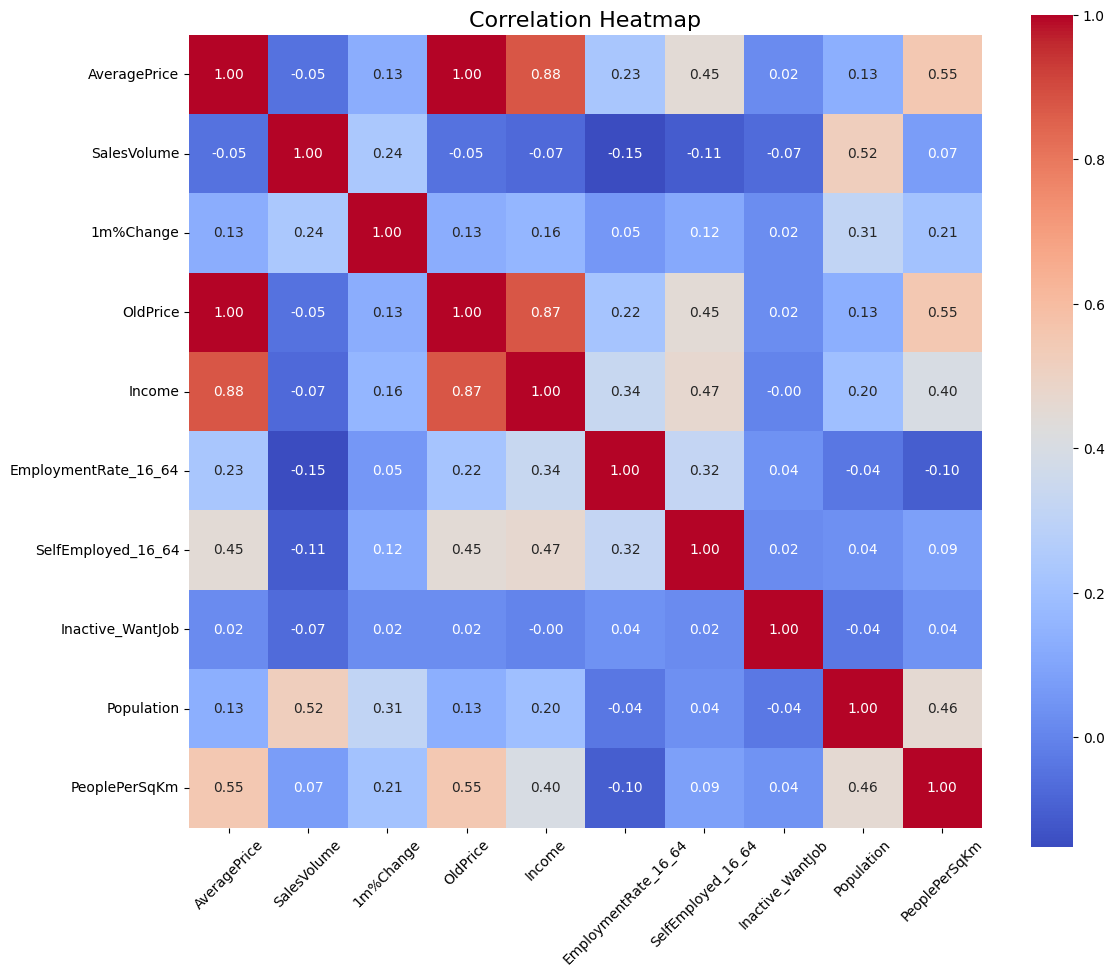

In [ ]:
# drop
df_corr = df[features].apply(pd.to_numeric, errors='coerce').dropna()


corr_matrix = df_corr.corr()

# Final heatmap
plt.figure(figsize=(12, 10))
sb.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Heatmap", fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

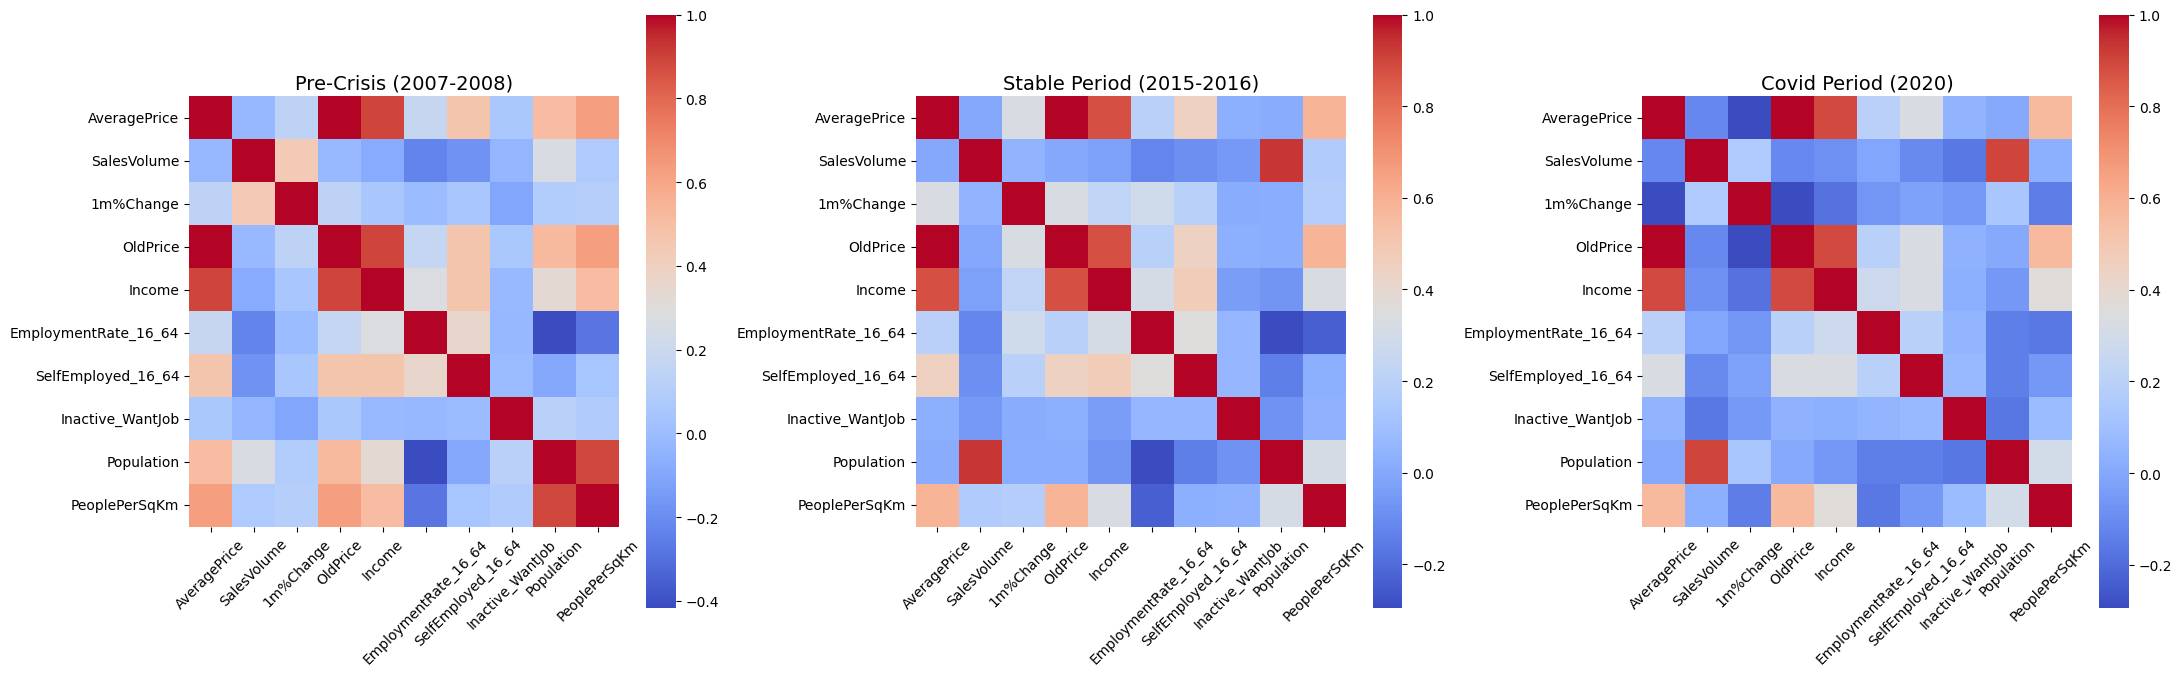

In [ ]:
# Ensure 'Year' column is integer
df['Year'] = pd.to_numeric(df['Year'], errors='coerce')

# Define three periods
periods = {
    "Pre-Crisis (2007-2008)": (2007, 2008),
    "Stable Period (2015-2016)": (2015, 2016),
    "Covid Period (2020)": (2020, 2020),
}

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(22, 7))
for ax, (title, (start, end)) in zip(axes, periods.items()):
    df_period = df[(df['Year'] >= start) & (df['Year'] <= end)]
    df_corr = df_period[features].apply(pd.to_numeric, errors='coerce').dropna()
    corr_matrix = df_corr.corr()
    sb.heatmap(corr_matrix, annot=False, fmt=".2f", cmap="coolwarm", square=True, ax=ax)
    ax.set_title(title, fontsize=14)
    ax.tick_params(axis='x', rotation=45)
    ax.tick_params(axis='y', rotation=0)

plt.tight_layout()
plt.show()


#Regression OLS


In [ ]:
data = pd.read_csv('/content/data_bm.csv')

In [ ]:
data.replace(['#', '*', '-', '~', '!'], np.nan, inplace=True)

features = [
    'AveragePrice', '1m%Change', '12m%Change', 'SalesVolume',
    'SemiDetachedPrice', 'NewPrice', 'OldPrice',
    'Income', 'EmploymentRate_16_64', 'SelfEmployed_16_64',
    'Inactive_WantJob', 'Population', 'PeoplePerSqKm'
]
target = ['Crisis_0809_Diff','Stable_1516_Diff','Covid_2020_Diff']

In [ ]:
data.dropna()

,RegionName,AreaCode,Year,AveragePrice,1m%Change,12m%Change,SalesVolume,SemiDetachedPrice,NewPrice,OldPrice,...,UnemploymentRate_16_64,UnemploymentRate_16plus,Inactive_WantJob,Inactive_NoJob,Population,TotalArea,PeoplePerSqKm,Crisis_0809_Diff,Stable_1516_Diff,Covid_2020_Diff
7,Adur,E07000223,2008,211198.2,-1.4,-1.3,62.2,232162.0,196509.7,210259.0,...,7,6.9,29.5,70.5,1459.266111,41.80389,34.907424,-43101,24208,20401
8,Adur,E07000223,2014,242298.2,1.0,12.5,96.7,270835.8,225425.6,241040.3,...,8.4,8,49.4,50.6,63525.000000,42.06600,1510.126943,-43101,24208,20401
9,Adur,E07000223,2015,264932.2,0.7,9.4,91.8,296597.9,245420.3,263558.9,...,7.4,6.9,39.6,60.4,63808.000000,42.06600,1516.854467,-43101,24208,20401
13,Amber Valley,E07000032,2008,136193.6,-1.0,-3.8,127.3,125785.6,193527.0,132565.7,...,5.5,5.5,10.5,89.5,455.106043,265.38650,1.714880,-17691,2616,12667
14,Amber Valley,E07000032,2014,135585.0,0.4,5.4,178.1,125509.8,193641.2,131874.7,...,3.6,3.9,14.8,85.2,123018.000000,265.38550,463.544542,-17691,2616,12667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2071,York,E06000014,2008,183766.2,-1.2,-5.0,189.0,188301.8,196204.0,182342.5,...,4.2,4.1,13.5,86.5,716.527514,271.98816,2.634407,-25242,13341,10448
2072,York,E06000014,2014,199576.1,0.6,6.7,313.5,206556.7,211568.8,198679.1,...,4.1,4,20.6,79.4,202206.000000,271.93580,743.579918,-25242,13341,10448
2073,York,E06000014,2015,214080.6,0.5,7.3,294.3,221795.5,228076.8,212991.0,...,4.3,4.3,23.7,76.3,203212.000000,271.93580,747.279321,-25242,13341,10448
2074,York,E06000014,2019,248339.8,0.0,2.6,270.0,260652.6,272745.3,247236.1,...,2.6,2.6,14.2,85.8,203877.000000,271.93580,749.724751,-25242,13341,10448


In [ ]:
print(data[features].isna().sum())
print(data['Crisis_0809_Diff'].isna().sum())


AveragePrice              0
1m%Change                 0
12m%Change                0
SalesVolume               0
SemiDetachedPrice         6
NewPrice                  0
OldPrice                  0
Income                    0
EmploymentRate_16_64      1
SelfEmployed_16_64        6
Inactive_WantJob         95
Population              240
PeoplePerSqKm           240
dtype: int64
0


In [ ]:
# three time periods
periods = {
    "Pre-Crisis (2007-2008)": (2007, 2008),
    "Stable Period (2015-2016)": (2015, 2016),
    "Covid Period (2020)": (2020, 2020),
}


In [ ]:
# Convert to numeric, set invalid values to NaN
data_clean = data[features].apply(pd.to_numeric, errors='coerce')

# Fill all missing values with column means (including target variable)
data_filled = data_clean.fillna(data_clean.mean())


In [ ]:
# Map target variable for each period
target_mapping = {
    "Pre-Crisis (2007-2008)": 'Crisis_0809_Diff',
    "Stable Period (2015-2016)": 'Stable_1516_Diff',
    "Covid Period (2020)": 'Covid_2020_Diff'
}

# Add Year column for filtering
data_filled['Year'] = data['Year']

# Loop through each period
for label, (start_year, end_year) in periods.items():
    print(f"\n========== {label} ==========\n")

    target_col = target_mapping[label]

    # Ensure target variable is numeric and fill missing values
    data_filled[target_col] = pd.to_numeric(data[target_col], errors='coerce')
    data_filled[target_col] = data_filled[target_col].fillna(data_filled[target_col].mean())

    # Filter data for the current period
    df_period = data_filled[(data_filled['Year'] >= start_year) & (data_filled['Year'] <= end_year)]

    # Construct X and y
    X = sm.add_constant(df_period[features])
    y = df_period[target_col]

    # Fit OLS regression
    model = sm.OLS(y, X).fit()
    print(model.summary())

    # Compute VIF
    vif_df = pd.DataFrame()
    vif_df['Variable'] = X.columns
    vif_df['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    print("\nVIF:")
    print(vif_df)



========== Pre-Crisis (2007-2008) ==========

                            OLS Regression Results                            
Dep. Variable:       Crisis_0809_Diff   R-squared:                       0.748
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     154.5
Date:                Sat, 09 Aug 2025   Prob (F-statistic):          1.13e-192
Time:                        12:46:18   Log-Likelihood:                -7208.3
No. Observations:                 692   AIC:                         1.444e+04
Df Residuals:                     678   BIC:                         1.451e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

#new

In [ ]:
# Read data
df = pd.read_csv('/content/data_bm.csv')

# Replace special symbols with NaN
df.replace(['#', '*', '-', '~', '!'], np.nan, inplace=True)

# Convert all columns to numeric where possible (non-numeric remain unchanged)
df = df.apply(pd.to_numeric, errors='ignore')

# Fill missing values with column means (numeric columns only)
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())


/tmp/ipython-input-752337990.py:11: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')


In [ ]:
# Feature set used for modeling/analysis
features = [
    'AveragePrice', 'SalesVolume', '1m%Change', 'OldPrice',
    'Income', 'EmploymentRate_16_64', 'SelfEmployed_16_64',
    'Inactive_WantJob', 'Population', 'PeoplePerSqKm'
]

# Year ranges for the three periods (inclusive)
periods = {
    'Crisis_0809': (2007, 2008),
    'Stable_1516': (2015, 2016),
    'Covid_2020': (2020, 2020)
}

# Extra target/label columns computed externally (e.g., period differences)
extra_cols = ['Crisis_0809_Diff', 'Stable_1516_Diff', 'Covid_2020_Diff']

In [ ]:
# Store results
raw_dfs = {}     # Unstandardized data (keeps RegionName etc.)
adf_dfs = {}     # Standardized data (for BallMapper)

for period, (start, end) in periods.items():
    # 1. Filter by year range
    sub_df = df[(df['Year'] >= start) & (df['Year'] <= end)].copy()

    # 2. Clean data (convert to numeric + drop missing)
    cleaned = sub_df[features + extra_cols].apply(pd.to_numeric, errors='coerce').dropna()

    # 3. Save unstandardized data (with identifiers and targets)
    raw_dfs[period] = sub_df.loc[cleaned.index, ['RegionName', 'AreaCode', 'Year'] + features + extra_cols].reset_index(drop=True)

    # 4. Standardize features
    scaler = StandardScaler()
    adf = scaler.fit_transform(cleaned[features])
    adf_dfs[period] = pd.DataFrame(adf, columns=features)


In [ ]:
raw_dfs['Crisis_0809']

,RegionName,AreaCode,Year,AveragePrice,SalesVolume,1m%Change,OldPrice,Income,EmploymentRate_16_64,SelfEmployed_16_64,Inactive_WantJob,Population,PeoplePerSqKm,Crisis_0809_Diff,Stable_1516_Diff,Covid_2020_Diff
0,Aberdeenshire,S12000034,2007,167845.2,516.7,1.8,161613.5,17485.0,80.5,10.4,23.0,124407.161460,1231.966270,-13628,-2218,7645
1,Aberdeenshire,S12000034,2008,179441.2,383.3,0.1,172388.3,18400.0,80.2,10.5,33.2,124407.161460,1231.966270,-13628,-2218,7645
2,Adur,E07000223,2007,214815.8,129.3,1.1,213926.7,13763.0,81.8,11.7,17.9,1456.036747,34.830174,-43101,24208,20401
3,Adur,E07000223,2008,211198.2,62.2,-1.4,210259.0,13972.0,77.4,10.3,29.5,1459.266111,34.907424,-43101,24208,20401
4,Amber Valley,E07000032,2007,141795.8,224.5,0.3,138087.1,13938.0,75.4,10.9,20.5,452.573888,1.705339,-17691,2616,12667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
687,Wyre,E07000128,2008,151634.9,105.4,-0.8,145923.5,14537.0,68.6,8.8,26.5,392.105650,1.387707,-19713,817,1866
688,Wyre Forest,E07000239,2007,157858.3,160.8,0.4,157106.2,13621.0,67.4,7.0,22.8,502.385575,2.570987,-20606,7103,1445
689,Wyre Forest,E07000239,2008,154103.9,76.7,-0.9,153337.5,14029.0,74.3,10.0,26.2,502.825685,2.573240,-20606,7103,1445
690,York,E06000014,2007,193590.9,344.5,0.5,192169.2,14880.0,75.2,8.0,15.7,707.821252,2.602397,-25242,13341,10448


In [ ]:
raw_dfs['Crisis_0809'].isnull().sum()

,0
RegionName,0
AreaCode,0
Year,0
AveragePrice,0
SalesVolume,0
1m%Change,0
OldPrice,0
Income,0
EmploymentRate_16_64,0
SelfEmployed_16_64,0


/tmp/ipython-input-1290185798.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_palette=cm.get_cmap("gist_rainbow"),


     Crisis_0809_Diff
0            -13628.0
1            -13628.0
2            -43101.0
3            -43101.0
4            -17691.0
..                ...
687          -19713.0
688          -20606.0
689          -20606.0
690          -25242.0
691          -25242.0

[692 rows x 1 columns]


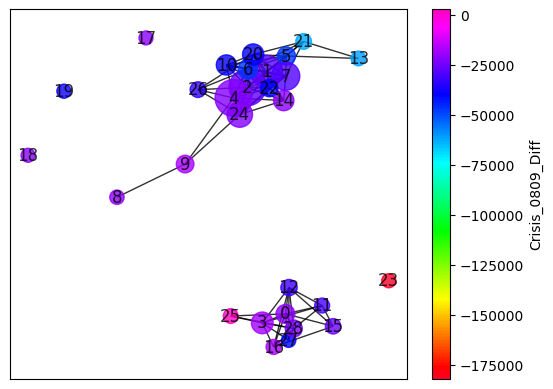

In [ ]:
# Example: 2008–2009 period
coloring_var = 'Crisis_0809_Diff'
eps = 3.3
layout_seed = 444

# Step 1: Construct coloring data
coloring_df = pd.DataFrame(
    raw_dfs['Crisis_0809'][coloring_var].astype(float)
)

# Step 2: Build Ball Mapper object (use standardized features)
bm = pbm.BallMapper(X=adf_dfs['Crisis_0809'], eps=eps, coloring_df=coloring_df)

# Step 3: Plot Ball Mapper graph
pos = nx.spring_layout(bm.Graph, seed=layout_seed, k=1, iterations=100)
bm.draw_networkx(
    coloring_variable=coloring_var,
    color_palette=cm.get_cmap("gist_rainbow"),
    colorbar=True,
    colorbar_label=coloring_var,
    pos=pos
)


In [ ]:
print(adf_dfs['Crisis_0809'])

[[-0.29074331  1.31882275  2.12634431 ... -0.06369971  2.32276248
   2.22976073]
 [-0.14715913  0.65196718  0.32234067 ...  1.51525364  2.32276248
   2.22976073]
 [ 0.2908568  -0.61775783  1.38351928 ... -0.85317638 -0.43508264
  -0.43710337]
 ...
 [-0.46089105 -0.88070088 -0.73883794 ...  0.43165821 -0.45646356
  -0.50896225]
 [ 0.0280455   0.45800919  0.74681212 ... -1.19373494 -0.45186542
  -0.50889729]
 [-0.09360605 -0.31932246 -1.05719152 ... -1.53429351 -0.45167014
  -0.50882598]]


In [ ]:
pb = bm.points_and_balls()
raw = raw_dfs['Crisis_0809'].reset_index().rename(columns={'index': 'point'})
mapped_0809 = raw.merge(pb, on='point')


In [ ]:
mapped_0809

,point,RegionName,AreaCode,Year,AveragePrice,SalesVolume,1m%Change,OldPrice,Income,EmploymentRate_16_64,SelfEmployed_16_64,Inactive_WantJob,Population,PeoplePerSqKm,Crisis_0809_Diff,Stable_1516_Diff,Covid_2020_Diff,ball
0,0,Aberdeenshire,S12000034,2007,167845.2,516.7,1.8,161613.5,17485.0,80.5,10.4,23.0,124407.161460,1231.966270,-13628,-2218,7645,0
1,1,Aberdeenshire,S12000034,2008,179441.2,383.3,0.1,172388.3,18400.0,80.2,10.5,33.2,124407.161460,1231.966270,-13628,-2218,7645,0
2,1,Aberdeenshire,S12000034,2008,179441.2,383.3,0.1,172388.3,18400.0,80.2,10.5,33.2,124407.161460,1231.966270,-13628,-2218,7645,3
3,2,Adur,E07000223,2007,214815.8,129.3,1.1,213926.7,13763.0,81.8,11.7,17.9,1456.036747,34.830174,-43101,24208,20401,1
4,3,Adur,E07000223,2008,211198.2,62.2,-1.4,210259.0,13972.0,77.4,10.3,29.5,1459.266111,34.907424,-43101,24208,20401,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1873,690,York,E06000014,2007,193590.9,344.5,0.5,192169.2,14880.0,75.2,8.0,15.7,707.821252,2.602397,-25242,13341,10448,7
1874,691,York,E06000014,2008,183766.2,189.0,-1.2,182342.5,14956.0,76.5,7.8,13.5,716.527514,2.634407,-25242,13341,10448,1
1875,691,York,E06000014,2008,183766.2,189.0,-1.2,182342.5,14956.0,76.5,7.8,13.5,716.527514,2.634407,-25242,13341,10448,2
1876,691,York,E06000014,2008,183766.2,189.0,-1.2,182342.5,14956.0,76.5,7.8,13.5,716.527514,2.634407,-25242,13341,10448,4


In [ ]:
grouped_data_0809 = mapped_0809.groupby("ball")["RegionName"].unique()
print(grouped_data_0809)
ball_counts_0809 = mapped_0809.groupby("ball")["RegionName"].count()
ball_counts_0809

ball
0     [Aberdeenshire, Angus, Argyll and Bute, Bedfor...
1     [Adur, Amber Valley, Arun, Ashford, Babergh, B...
2     [Adur, Amber Valley, Arun, Ashfield, Ashford, ...
3     [Aberdeenshire, Angus, Argyll and Bute, Bedfor...
4     [Amber Valley, Arun, Ashfield, Barking and Dag...
5     [Barnet, Bath and North East Somerset, Brent, ...
6     [Barnet, Brent, Brentwood, Brighton and Hove, ...
7     [Amber Valley, Arun, Ashfield, Basildon, Basin...
8             [Birmingham, Bradford, Leeds, Manchester]
9     [Barnsley, Birmingham, Bolton, Bradford, Cardi...
10    [Arun, Bath and North East Somerset, Bexley, B...
11    [Bournemouth Christchurch and Poole, Buckingha...
12    [Bournemouth Christchurch and Poole, Buckingha...
13    [Camden, Elmbridge, Hammersmith and Fulham, Is...
14    [Amber Valley, Barking and Dagenham, Bassetlaw...
15    [Bournemouth Christchurch and Poole, Cheshire ...
16    [City of Edinburgh, City of Glasgow, County Du...
17                                     [Cit

,RegionName
ball,
0,47
1,244
2,339
3,82
4,341
5,42
6,52
7,180
8,4


In [ ]:
ball_list = [13, 21,]
regions = grouped_data_0809.loc[ball_list].explode().unique()
print(regions)

['Camden' 'Elmbridge' 'Hammersmith and Fulham' 'Islington'
 'Richmond upon Thames' 'Wandsworth' 'Brentwood' 'Epping Forest'
 'Epsom and Ewell' 'Guildford' 'Horsham' 'Kingston upon Thames' 'Merton'
 'Mole Valley' 'Waverley' 'Windsor and Maidenhead']


In [ ]:
ball_list = [23]
regions = grouped_data_0809.loc[ball_list].explode().unique()
print(regions)

['Kensington and Chelsea']


In [ ]:

ball_list = [25,3,0,12,11,15,16]
regions = grouped_data_0809.loc[ball_list].explode().unique()
print(regions)

['Argyll and Bute' 'Moray' 'Na h-Eileanan Siar' 'Orkney Islands'
 'Shetland Islands' 'Aberdeenshire' 'Angus' 'Bedford'
 'Bournemouth Christchurch and Poole' 'Central Bedfordshire'
 'Cheshire East' 'Cheshire West and Chester' 'City of Aberdeen'
 'City of Dundee' 'Clackmannanshire' 'Cornwall' 'County Durham' 'Dorset'
 'Dumfries and Galloway' 'East Ayrshire' 'East Dunbartonshire'
 'East Hertfordshire' 'East Lothian' 'East Renfrewshire' 'East Suffolk'
 'Falkirk' 'Fife' 'Gateshead' 'Highland' 'Inverclyde' 'Midlothian'
 'North Ayrshire' 'North Lanarkshire' 'North Northamptonshire'
 'Northumberland' 'Perth and Kinross' 'Renfrewshire' 'Scottish Borders'
 'Shropshire' 'Somerset' 'South Ayrshire' 'South Lanarkshire' 'Stevenage'
 'Stirling' 'Welwyn Hatfield' 'West Dunbartonshire' 'West Lothian'
 'West Northamptonshire' 'West Suffolk' 'Wiltshire' 'Buckinghamshire'
 'City of Edinburgh' 'St Albans' 'City of Glasgow']


In [ ]:
columns_to_avg = [
    'AveragePrice', 'SalesVolume', '1m%Change', 'OldPrice',
    'Income', 'EmploymentRate_16_64', 'SelfEmployed_16_64',
    'Inactive_WantJob', 'Population', 'PeoplePerSqKm', 'Crisis_0809_Diff'
]

ball_means = mapped_0809.groupby('ball')[columns_to_avg].mean().round(2)

# 计算每个球的样本数量
ball_counts = mapped_0809.groupby('ball').size().rename('Count')

# 合并为一个总表
ball_summary = pd.concat([ball_means, ball_counts], axis=1)

In [ ]:
ball_summary

,AveragePrice,SalesVolume,1m%Change,OldPrice,Income,EmploymentRate_16_64,SelfEmployed_16_64,Inactive_WantJob,Population,PeoplePerSqKm,Crisis_0809_Diff,Count
ball,,,,,,,,,,,,
0,157075.12,437.43,0.72,151322.19,15440.00,76.18,9.20,23.14,124407.16,1231.97,-20468.45,47
1,196274.40,213.23,0.17,193126.55,16317.38,76.40,10.32,20.89,867.36,15.47,-28729.63,244
2,184446.47,172.54,-0.60,181541.17,15822.27,74.64,9.53,24.72,1161.74,20.69,-27508.72,339
3,147599.14,265.34,-0.12,142367.54,15305.93,75.43,8.74,23.69,124407.16,1231.97,-18385.94,82
4,151454.07,231.45,-0.24,148854.85,14070.57,71.76,7.89,23.22,1357.69,20.60,-22051.39,341
5,295114.36,333.74,0.89,293402.92,20662.38,73.34,11.65,21.05,2635.81,59.88,-46820.64,42
6,288724.46,190.26,-0.77,286711.32,20564.46,72.71,11.51,27.41,3131.00,90.05,-46966.23,52
7,198298.99,173.75,-0.56,194937.16,16790.68,76.52,9.14,19.08,1003.74,16.70,-29269.35,180
8,138296.75,1292.00,0.48,136913.08,12144.75,66.47,6.38,20.10,2638.66,13.78,-20524.50,4


In [ ]:
# Assume you already have ball_summary with ball IDs as index and feature means as columns

# Define custom ball groups
ball_blue = [13, 21]              # Example: Blue region
ball_down = [25, 3, 0, 12, 11, 15, 16]   # Example: upper part of the graph
ball_23 = [23]                    # Single ball 23

# Compute mean values for each group
blue_means = ball_summary.loc[ball_blue].mean()
down_means = ball_summary.loc[ball_down].mean()
ball23_means = ball_summary.loc[ball_23].mean()

# Combine results into one table
grouped_means = pd.DataFrame({
    "Ball Blue": blue_means,
    "Ball Down": down_means,
    "Ball 23": ball23_means
})

# Display rounded results
grouped_means.round(2)


,Ball Blue,Ball down,Ball 23
AveragePrice,401601.86,162136.27,828545.35
SalesVolume,255.20,534.33,224.55
1m%Change,0.05,0.21,0.55
OldPrice,399736.57,157717.50,837437.45
Income,28390.00,15600.09,56780.00
EmploymentRate_16_64,73.53,75.97,65.70
SelfEmployed_16_64,12.96,9.81,13.00
Inactive_WantJob,24.93,22.94,19.20
Population,5656.98,124407.16,14096.89
PeoplePerSqKm,262.28,1231.97,1162.18


from matplotlib import pyplot as plt
_df_0['Ball Blue'].plot(kind='hist', bins=20, title='Ball Blue')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Ball down'].plot(kind='hist', bins=20, title='Ball down')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['Ball 23'].plot(kind='hist', bins=20, title='Ball 23')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3.plot(kind='scatter', x='Ball Blue', y='Ball down', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='Ball down', y='Ball 23', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5['Ball Blue'].plot(kind='line', figsize=(8, 4), title='Ball Blue')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_6['Ball down'].plot(kind='line', figsize=(8, 4), title='Ball down')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_7['Ball 23'].plot(kind='line', figsize=(8, 4), title='Ball 23')
plt.gca().spines[['top', 'right']].set_visible(False)

<Axes: >

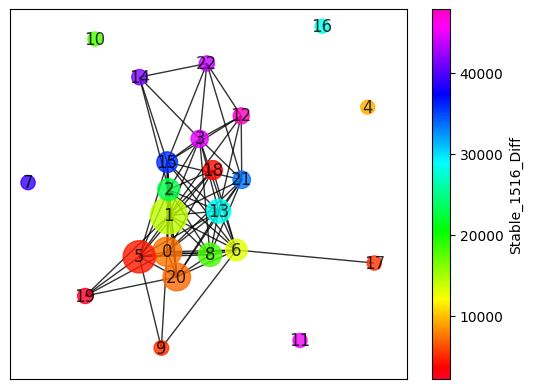

In [ ]:
# Example: 2015–2016 period
coloring_var = 'Stable_1516_Diff'
eps = 3.5
layout_seed = 445

# Step 1: Construct coloring data
coloring_df = pd.DataFrame(
    raw_dfs['Stable_1516'][coloring_var].astype(float).reset_index(drop=True)
)

# Step 2: Build Ball Mapper object (use standardized features)
bm = pbm.BallMapper(X=adf_dfs['Stable_1516'], eps=eps, coloring_df=coloring_df)

# Step 3: Plot Ball Mapper graph
pos = nx.spring_layout(bm.Graph, seed=layout_seed, k=2, iterations=100)
bm.draw_networkx(
    coloring_variable=coloring_var,
    color_palette=cm.get_cmap("gist_rainbow"),
    colorbar=True,
    colorbar_label=coloring_var,
    pos=pos
)


In [ ]:
pb = bm.points_and_balls()
raw = raw_dfs['Stable_1516'].reset_index().rename(columns={'index': 'point'})
mapped_1516 = raw.merge(pb, on='point')
grouped_data_1516 = mapped_1516.groupby("ball")["RegionName"].unique()
print(grouped_data_1516)
ball_counts_1516 = mapped_1516.groupby("ball")["RegionName"].count()
ball_counts_1516

ball
0     [Aberdeenshire, Adur, Amber Valley, Angus, Arg...
1     [Adur, Amber Valley, Angus, Argyll and Bute, A...
2     [Amber Valley, Arun, Barking and Dagenham, Bas...
3     [Barnet, Brent, Brighton and Hove, Bromley, Cr...
4                                          [Birmingham]
5     [Amber Valley, Angus, Argyll and Bute, Arun, A...
6     [Bexley, Bolton, Bournemouth Christchurch and ...
7                      [Camden, Hammersmith and Fulham]
8     [Adur, Argyll and Bute, Arun, Ashford, Basildo...
9     [City of Edinburgh, City of Glasgow, Fife, Som...
10                                     [City of London]
11                                [City of Westminster]
12    [Elmbridge, Epping Forest, Guildford, Hertsmer...
13    [Adur, Basildon, Basingstoke and Deane, Bexley...
14    [Brent, Hackney, Haringey, Islington, Lambeth,...
15    [Bath and North East Somerset, Bedford, Bexley...
16                             [Kensington and Chelsea]
17                                    [Corn

,RegionName
ball,
0,122
1,216
2,53
3,19
4,1
5,157
6,50
7,2
8,64


In [ ]:
target_region = "Kensington and Chelsea"

# find the city in ball
ball_with_region = [ball for ball, regions in grouped_data_1516.items() if target_region in regions]

print(ball_with_region)


[16]


In [ ]:
columns_to_avg = [
    'AveragePrice', 'SalesVolume', '1m%Change', 'OldPrice',
    'Income', 'EmploymentRate_16_64', 'SelfEmployed_16_64',
    'Inactive_WantJob', 'Population', 'PeoplePerSqKm', 'Stable_1516_Diff'
]

ball_means = mapped_1516.groupby('ball')[columns_to_avg].mean().round(2)


ball_counts = mapped_1516.groupby('ball').size().rename('Count')

ball_summary = pd.concat([ball_means, ball_counts], axis=1)
ball_summary

,AveragePrice,SalesVolume,1m%Change,OldPrice,Income,EmploymentRate_16_64,SelfEmployed_16_64,Inactive_WantJob,Population,PeoplePerSqKm,Stable_1516_Diff,Count
ball,,,,,,,,,,,,
0,168917.86,226.93,0.36,165681.87,18487.95,76.06,9.56,27.93,151546.32,994.61,7421.86,122
1,206987.94,195.34,0.56,203544.53,19716.80,75.64,10.88,23.99,133958.58,930.87,14240.15,216
2,223869.73,257.08,0.84,221243.52,18525.58,71.99,10.53,26.08,192678.47,2871.71,22863.47,53
3,410414.79,317.56,0.94,410000.13,24387.21,73.26,13.16,26.69,275790.53,5240.48,44859.21,19
4,144542.20,1101.20,0.40,144311.40,14239.00,61.40,7.80,20.20,1114932.00,4163.47,9463.00,1
5,138181.03,206.29,0.37,135288.02,16893.58,71.78,8.54,24.67,154334.27,1257.88,4374.61,157
6,187983.58,487.21,0.54,185351.61,18958.23,74.54,9.58,24.02,311192.25,1619.83,13007.68,50
7,783953.15,205.60,0.40,781567.65,41525.50,73.10,15.30,35.75,204139.00,10775.56,39027.50,2
8,232293.08,201.11,0.69,228713.54,20174.98,78.12,12.22,33.89,128874.88,1134.35,18129.02,64


/tmp/ipython-input-3809913382.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_palette=cm.get_cmap("gist_rainbow"),


<Axes: >

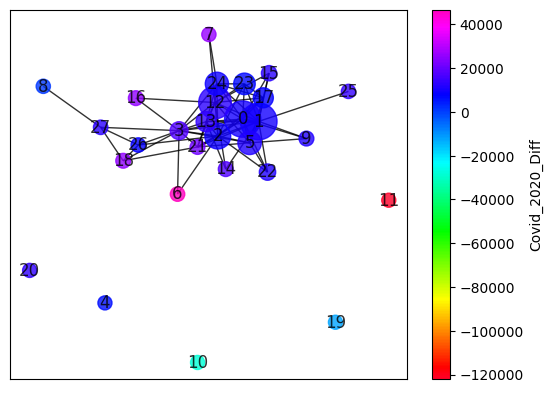

In [ ]:
# Example: 2020 period
coloring_var = 'Covid_2020_Diff'
eps = 3.5
layout_seed = 446

# Step 1: Construct coloring data
coloring_df = pd.DataFrame(
    raw_dfs['Covid_2020'][coloring_var].astype(float).reset_index(drop=True)
)

# Step 2: Build Ball Mapper object (use standardized features)
bm = pbm.BallMapper(X=adf_dfs['Covid_2020'], eps=eps, coloring_df=coloring_df)

# Step 3: Plot Ball Mapper graph
pos = nx.spring_layout(bm.Graph, seed=layout_seed, k=1, iterations=100)
bm.draw_networkx(
    coloring_variable=coloring_var,
    color_palette=cm.get_cmap("gist_rainbow"),
    colorbar=True,
    colorbar_label=coloring_var,
    pos=pos
)


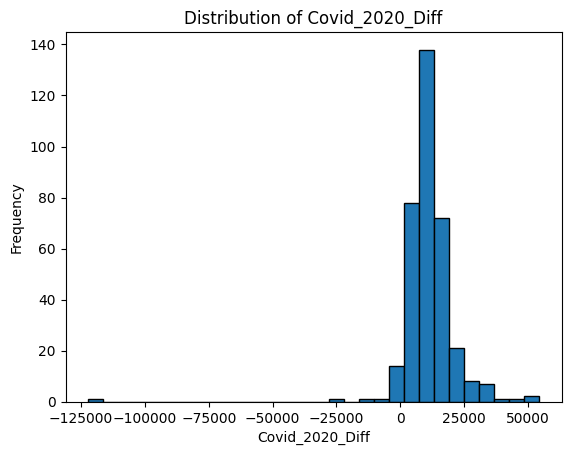

In [ ]:
import matplotlib.pyplot as plt

raw_dfs['Covid_2020']['Covid_2020_Diff'].hist(bins=30, edgecolor='black')
plt.title('Distribution of Covid_2020_Diff')
plt.xlabel('Covid_2020_Diff')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()


In [ ]:
pb = bm.points_and_balls()
raw = raw_dfs['Covid_2020'].reset_index().rename(columns={'index': 'point'})
mapped_2020 = raw.merge(pb, on='point')
grouped_data_2020 = mapped_2020.groupby("ball")["RegionName"].unique()
print(grouped_data_2020)
ball_counts_2020 = mapped_2020.groupby("ball")["RegionName"].count()
ball_counts_2020

ball
0     [Aberdeenshire, Adur, Amber Valley, Angus, Arg...
1     [Amber Valley, Angus, Argyll and Bute, Arun, A...
2     [Angus, Argyll and Bute, Barking and Dagenham,...
3     [Barnet, Bexley, Brighton and Hove, Bromley, C...
4                                          [Birmingham]
5     [Arun, Barnsley, Basildon, Bexley, Bolton, Bou...
6                       [Brent, Merton, Waltham Forest]
7                               [Brentwood, Chichester]
8                      [Camden, Hammersmith and Fulham]
9     [City of Edinburgh, City of Glasgow, Fife, Som...
10                                     [City of London]
11                                [City of Westminster]
12    [Adur, Amber Valley, Arun, Ashford, Babergh, B...
13    [Adur, Babergh, Bath and North East Somerset, ...
14    [Derbyshire Dales, South Hams, Torridge, Uttle...
15    [East Cambridgeshire, Eastbourne, Harlow, Orkn...
16    [Elmbridge, Hertsmere, Mole Valley, Richmond u...
17    [Amber Valley, Barnsley, Blackpool, B

,RegionName
ball,
0,210
1,217
2,89
3,24
4,1
5,67
6,3
7,2
8,2


In [ ]:
target_region = "Kensington and Chelsea"

# find ball in city
ball_with_region = [ball for ball, regions in grouped_data_2020.items() if target_region in regions]

print(ball_with_region)

[19]


In [ ]:
columns_to_avg = [
    'AveragePrice', 'SalesVolume', '1m%Change', 'OldPrice',
    'Income', 'EmploymentRate_16_64', 'SelfEmployed_16_64',
    'Inactive_WantJob', 'Population', 'PeoplePerSqKm', 'Covid_2020_Diff'
]

ball_means = mapped_2020.groupby('ball')[columns_to_avg].mean().round(2)

ball_counts = mapped_2020.groupby('ball').size().rename('Count')

ball_summary = pd.concat([ball_means, ball_counts], axis=1)
ball_summary

,AveragePrice,SalesVolume,1m%Change,OldPrice,Income,EmploymentRate_16_64,SelfEmployed_16_64,Inactive_WantJob,Population,PeoplePerSqKm,Covid_2020_Diff,Count
ball,,,,,,,,,,,,
0,228607.86,180.41,0.43,224198.54,20716.46,76.92,9.50,23.55,161244.26,1154.84,9873.20,210
1,195729.02,172.70,0.53,191587.28,19534.22,75.40,9.45,23.83,154835.49,1188.28,10400.12,217
2,230768.40,174.54,0.40,227895.61,19760.99,72.78,9.44,22.90,192071.51,2516.78,9284.25,89
3,457745.46,199.83,0.30,456237.32,27197.46,75.69,11.83,23.48,257099.04,4110.28,17227.29,24
4,185537.60,816.20,0.40,185559.50,15849.00,65.40,9.50,14.00,1148692.00,4289.54,6203.00,1
5,220677.43,349.78,0.50,217285.41,20466.05,75.47,9.27,23.92,305184.00,1728.05,11242.00,67
6,517331.53,164.30,0.93,519297.80,28675.33,73.47,11.90,22.93,280205.33,6976.75,46757.33,3
7,428796.95,119.35,0.35,422301.40,28728.50,65.50,14.10,21.90,100185.50,330.79,25774.50,2
8,789265.35,148.70,-0.05,785436.20,42904.00,74.00,14.75,32.40,200661.50,10610.81,1165.00,2


# new variable


In [ ]:
# Construct affordability ratio: income to average house price
df['AffordabilityRatio'] = df['Income'] / df['AveragePrice']

# Construct old-to-new price ratio
df['OldVsNewPriceRatio'] = df['OldPrice'] / df['NewPrice']


In [ ]:
raw_dfs

{'Crisis_0809':         RegionName   AreaCode  Year  AveragePrice  SalesVolume  1m%Change  \
 0    Aberdeenshire  S12000034  2007      167845.2        516.7        1.8   
 1    Aberdeenshire  S12000034  2008      179441.2        383.3        0.1   
 2             Adur  E07000223  2007      214815.8        129.3        1.1   
 3             Adur  E07000223  2008      211198.2         62.2       -1.4   
 4     Amber Valley  E07000032  2007      141795.8        224.5        0.3   
 ..             ...        ...   ...           ...          ...        ...   
 687           Wyre  E07000128  2008      151634.9        105.4       -0.8   
 688    Wyre Forest  E07000239  2007      157858.3        160.8        0.4   
 689    Wyre Forest  E07000239  2008      154103.9         76.7       -0.9   
 690           York  E06000014  2007      193590.9        344.5        0.5   
 691           York  E06000014  2008      183766.2        189.0       -1.2   
 
      OldPrice   Income  EmploymentRate_16_64  

/tmp/ipython-input-3933863881.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_palette=cm.get_cmap("gist_rainbow"),


<Axes: >

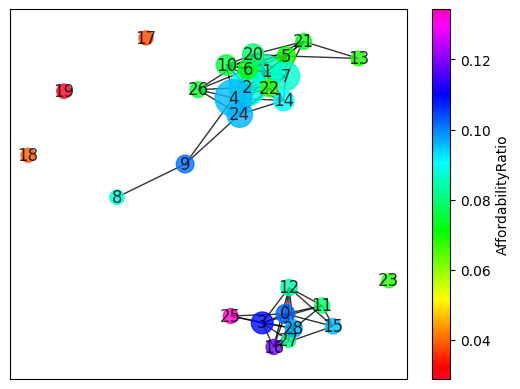

In [ ]:
# Example: 2008–2009, construct affordability ratio directly
coloring_df = pd.DataFrame(
    (raw_dfs['Crisis_0809']['Income'] / raw_dfs['Crisis_0809']['AveragePrice']).astype(float).reset_index(drop=True),
    columns=['AffordabilityRatio']
)

eps = 3.3
layout_seed = 444

# Pass the constructed coloring_df to Ball Mapper
bm = pbm.BallMapper(
    X=adf_dfs['Crisis_0809'],  # standardized features
    eps=eps,
    coloring_df=coloring_df
)

# Plot Ball Mapper graph
pos = nx.spring_layout(bm.Graph, seed=layout_seed, k=1, iterations=100)
bm.draw_networkx(
    coloring_variable='AffordabilityRatio',
    color_palette=cm.get_cmap("gist_rainbow"),
    colorbar=True,
    colorbar_label='AffordabilityRatio',
    pos=pos
)


/tmp/ipython-input-280123895.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_palette=cm.get_cmap("gist_rainbow"),


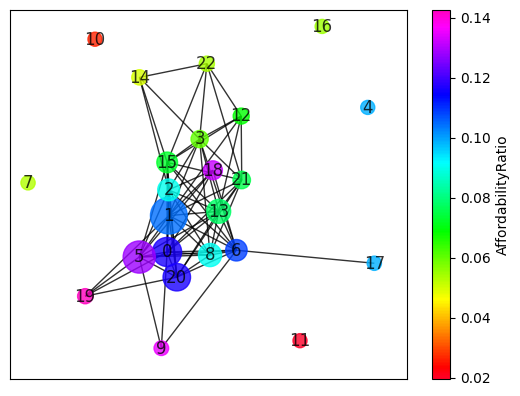

In [ ]:

def plot_affordability(period_key, eps=3.3, layout_seed=444):
    """
    Plot Ball Mapper graph of affordability ratio for a given period.
    period_key: 'Crisis_0809' / 'Stable_1516' / 'Covid_2020'
    """
    # Construct affordability ratio
    coloring_df = pd.DataFrame(
        (raw_dfs[period_key]['Income'] / raw_dfs[period_key]['AveragePrice']).astype(float).reset_index(drop=True),
        columns=['AffordabilityRatio']
    )

    # Build Ball Mapper object (use standardized features)
    bm = pbm.BallMapper(
        X=adf_dfs[period_key],
        eps=eps,
        coloring_df=coloring_df
    )

    # Plot Ball Mapper graph
    pos = nx.spring_layout(bm.Graph, seed=layout_seed, k=2, iterations=100)
    bm.draw_networkx(
        coloring_variable='AffordabilityRatio',
        color_palette=cm.get_cmap("gist_rainbow"),
        colorbar=True,
        colorbar_label='AffordabilityRatio',
        pos=pos
    )

# Example: plot for 2015–2016
plot_affordability('Stable_1516', eps=3.5, layout_seed=445)


/tmp/ipython-input-3858429344.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_palette=cm.get_cmap("gist_rainbow"),


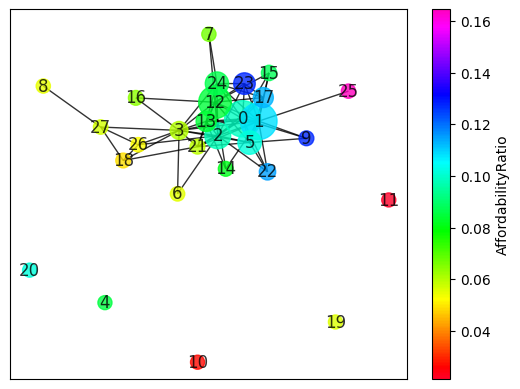

In [ ]:
plot_affordability('Covid_2020', eps=3.5, layout_seed=446)

# SelfEmployed_16_64

/tmp/ipython-input-3298573556.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_palette=cm.get_cmap("gist_rainbow"),


<Axes: >

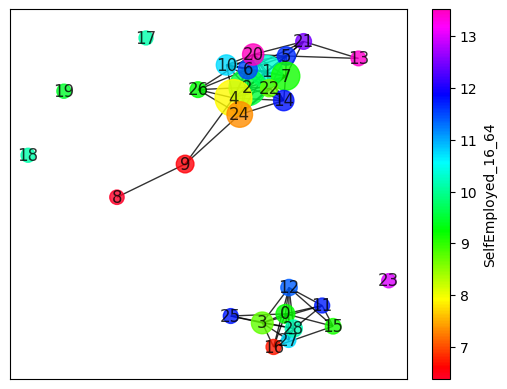

In [ ]:
# Example: 2008–2009 period
coloring_var = 'SelfEmployed_16_64'
eps = 3.3
layout_seed = 444

# Step 1: Construct coloring data
coloring_df = pd.DataFrame(
    raw_dfs['Crisis_0809'][coloring_var].astype(float)
)

# Step 2: Build Ball Mapper object (use standardized features)
bm = pbm.BallMapper(X=adf_dfs['Crisis_0809'], eps=eps, coloring_df=coloring_df)

# Step 3: Plot Ball Mapper graph
pos = nx.spring_layout(bm.Graph, seed=layout_seed, k=1, iterations=100)
bm.draw_networkx(
    coloring_variable=coloring_var,
    color_palette=cm.get_cmap("gist_rainbow"),
    colorbar=True,
    colorbar_label=coloring_var,
    pos=pos
)


/tmp/ipython-input-2765675921.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_palette=cm.get_cmap("gist_rainbow"),


<Axes: >

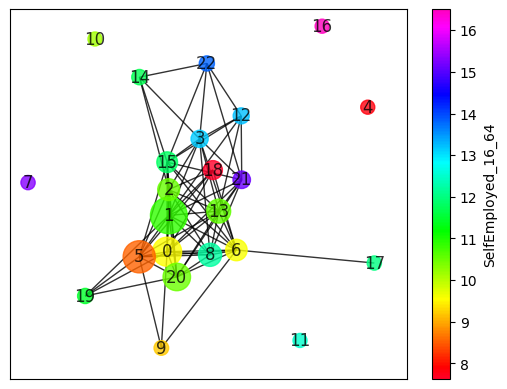

In [ ]:
# Example: 2015–2016 period
coloring_var = 'SelfEmployed_16_64'
eps = 3.5
layout_seed = 445

# Step 1: Construct coloring data
coloring_df = pd.DataFrame(
    raw_dfs['Stable_1516'][coloring_var].astype(float).reset_index(drop=True)
)

# Step 2: Build Ball Mapper object (use standardized features)
bm = pbm.BallMapper(X=adf_dfs['Stable_1516'], eps=eps, coloring_df=coloring_df)

# Step 3: Plot Ball Mapper graph
pos = nx.spring_layout(bm.Graph, seed=layout_seed, k=2, iterations=100)
bm.draw_networkx(
    coloring_variable=coloring_var,
    color_palette=cm.get_cmap("gist_rainbow"),
    colorbar=True,
    colorbar_label=coloring_var,
    pos=pos
)


/tmp/ipython-input-545913640.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_palette=cm.get_cmap("gist_rainbow"),


<Axes: >

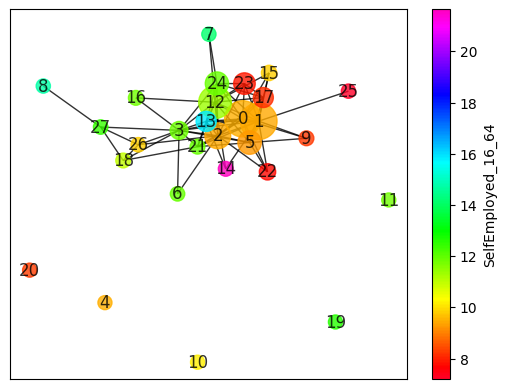

In [ ]:
# Example: 2020 period
coloring_var = 'SelfEmployed_16_64'
eps = 3.5
layout_seed = 446

# Step 1: Construct coloring data
coloring_df = pd.DataFrame(
    raw_dfs['Covid_2020'][coloring_var].astype(float).reset_index(drop=True)
)

# Step 2: Build Ball Mapper object (use standardized features)
bm = pbm.BallMapper(X=adf_dfs['Covid_2020'], eps=eps, coloring_df=coloring_df)

# Step 3: Plot Ball Mapper graph
pos = nx.spring_layout(bm.Graph, seed=layout_seed, k=1, iterations=100)
bm.draw_networkx(
    coloring_variable=coloring_var,
    color_palette=cm.get_cmap("gist_rainbow"),
    colorbar=True,
    colorbar_label=coloring_var,
    pos=pos
)


# 1m%change

<Axes: >

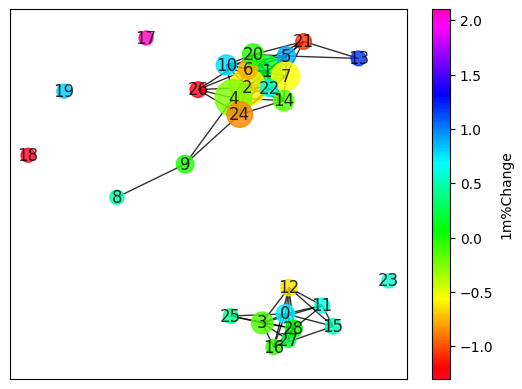

In [ ]:
# Example: 2008–2009 period
coloring_var = '1m%Change'
eps = 3.3
layout_seed = 444

# Step 1: Construct coloring data
coloring_df = pd.DataFrame(
    raw_dfs['Crisis_0809'][coloring_var].astype(float)
)

# Step 2: Build Ball Mapper object (use standardized features)
bm = pbm.BallMapper(X=adf_dfs['Crisis_0809'], eps=eps, coloring_df=coloring_df)

# Step 3: Plot Ball Mapper graph
pos = nx.spring_layout(bm.Graph, seed=layout_seed, k=1, iterations=100)
bm.draw_networkx(
    coloring_variable=coloring_var,
    color_palette=cm.get_cmap("gist_rainbow"),
    colorbar=True,
    colorbar_label=coloring_var,
    pos=pos
)


<Axes: >

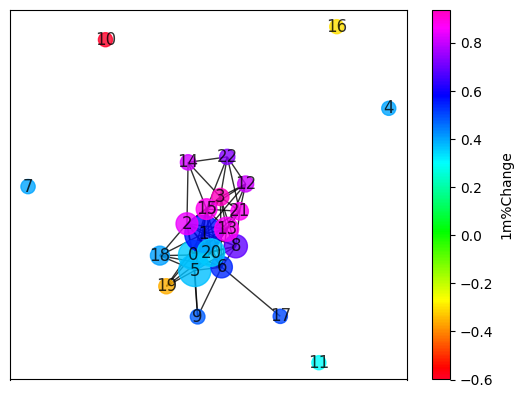

In [ ]:
# Example: 2015–2016 period
coloring_var = '1m%Change'
eps = 3.5
layout_seed = 445

# Step 1: Construct coloring data
coloring_df = pd.DataFrame(
    raw_dfs['Stable_1516'][coloring_var].astype(float).reset_index(drop=True)
)

# Step 2: Build Ball Mapper object (use standardized features)
bm = pbm.BallMapper(X=adf_dfs['Stable_1516'], eps=eps, coloring_df=coloring_df)

# Step 3: Plot Ball Mapper graph
pos = nx.spring_layout(bm.Graph, seed=layout_seed, k=1, iterations=100)
bm.draw_networkx(
    coloring_variable=coloring_var,
    color_palette=cm.get_cmap("gist_rainbow"),
    colorbar=True,
    colorbar_label=coloring_var,
    pos=pos
)


<Axes: >

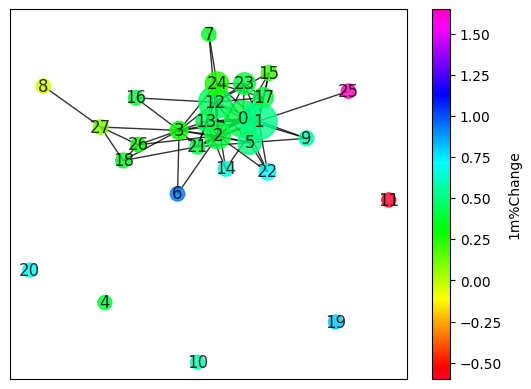

In [ ]:
# Example: 2020 period
coloring_var = '1m%Change'
eps = 3.5
layout_seed = 446

# Step 1: Construct coloring data
coloring_df = pd.DataFrame(
    raw_dfs['Covid_2020'][coloring_var].astype(float).reset_index(drop=True)
)

# Step 2: Build Ball Mapper object (use standardized features)
bm = pbm.BallMapper(X=adf_dfs['Covid_2020'], eps=eps, coloring_df=coloring_df)

# Step 3: Plot Ball Mapper graph
pos = nx.spring_layout(bm.Graph, seed=layout_seed, k=1, iterations=100)
bm.draw_networkx(
    coloring_variable=coloring_var,
    color_palette=cm.get_cmap("gist_rainbow"),
    colorbar=True,
    colorbar_label=coloring_var,
    pos=pos
)


# 2020 bm change



/tmp/ipython-input-3809913382.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_palette=cm.get_cmap("gist_rainbow"),


<Axes: >

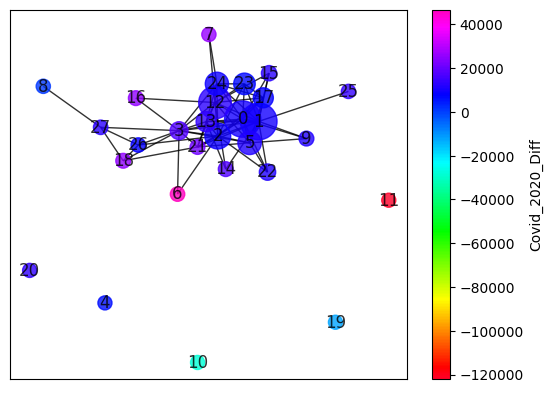

In [ ]:
# Example: 2020 period
coloring_var = 'Covid_2020_Diff'
eps = 3.5
layout_seed = 446

# Step 1: Construct coloring data
coloring_df = pd.DataFrame(
    raw_dfs['Covid_2020'][coloring_var].astype(float).reset_index(drop=True)
)

# Step 2: Build Ball Mapper object (use standardized features)
bm = pbm.BallMapper(X=adf_dfs['Covid_2020'], eps=eps, coloring_df=coloring_df)

# Step 3: Plot Ball Mapper graph
pos = nx.spring_layout(bm.Graph, seed=layout_seed, k=1, iterations=100)
bm.draw_networkx(
    coloring_variable=coloring_var,
    color_palette=cm.get_cmap("gist_rainbow"),
    colorbar=True,
    colorbar_label=coloring_var,
    pos=pos
)


In [ ]:
adf_dfs['Covid_2020']

,AveragePrice,SalesVolume,1m%Change,OldPrice,Income,EmploymentRate_16_64,SelfEmployed_16_64,Inactive_WantJob,Population,PeoplePerSqKm
0,-0.528396,0.942689,-1.426477,-0.552771,0.165565,0.752532,-0.568865,0.158941,-0.461797,-0.215056
1,0.354422,-0.948942,-1.033515,0.371964,-0.309512,1.599721,1.034069,-0.033523,-0.970164,-0.090264
2,-0.580528,-0.295035,0.538336,-0.586972,-0.421754,0.731869,-0.683360,1.359313,-0.448668,-0.527467
3,-0.802426,-0.256804,-0.247589,-0.803584,-0.358884,-0.755877,-0.769232,-0.402935,-0.461797,-0.215056
4,-0.860472,-0.433621,-1.033515,-0.848724,-0.244333,-0.073993,0.833702,-1.143589,-0.461797,-0.215056
...,...,...,...,...,...,...,...,...,...,...
341,-0.731116,-0.626369,0.538336,-0.714617,-0.709287,-0.714550,-0.082260,-0.185846,-0.363509,-0.611898
342,-0.014695,-0.295831,-0.640552,-0.030000,0.286510,0.669880,0.347097,-0.926501,-0.410738,-0.642164
343,-0.764282,-0.299813,-0.640552,-0.773628,-0.326384,1.207122,-0.139508,-1.322368,-0.580683,-0.561830
344,-0.497988,-0.713981,-0.247589,-0.477006,-0.404705,0.855848,1.492050,0.261101,-0.657919,-0.509365


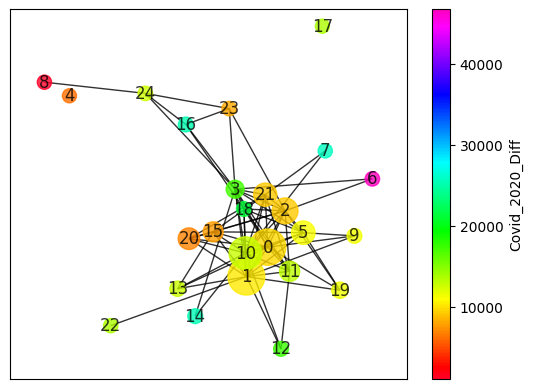

In [ ]:

regions_to_drop = ["Kensington and Chelsea", "City of Westminster", "City of London"]

def drop_regions_and_plot(period_key, regions_to_drop, eps, coloring_var, layout_seed=446):
    """
    Remove selected regions from a given period and re-plot Ball Mapper.
    period_key: one of 'Crisis_0809' / 'Stable_1516' / 'Covid_2020'
    regions_to_drop: list of region names to exclude
    eps: Ball Mapper epsilon
    coloring_var: column name used for coloring
    layout_seed: spring_layout seed for reproducibility
    """
    # 1) Locate row indices to drop in the raw (unstandardized) table (keeps alignment with adf)
    base = raw_dfs[period_key].reset_index(drop=True)   # contains RegionName and target columns
    drop_idx = base.index[base["RegionName"].isin(regions_to_drop)].tolist()

    # 2) Drop the same rows from standardized features and coloring column
    X_f = adf_dfs[period_key].drop(index=drop_idx).reset_index(drop=True)
    color_f = base[[coloring_var]].astype(float).drop(index=drop_idx).reset_index(drop=True)

    # 3) Recompute Ball Mapper and plot
    bm_f = pbm.BallMapper(X=X_f, eps=eps, coloring_df=color_f)
    pos_f = nx.spring_layout(bm_f.Graph, seed=layout_seed, k=1.5, iterations=100)
    bm_f.draw_networkx(
        coloring_variable=coloring_var,
        color_palette=cm.get_cmap("gist_rainbow"),
        colorbar=True,
        colorbar_label=coloring_var,
        pos=pos_f
    )
    return bm_f, pos_f, drop_idx

bm_f, pos_f, drop_idx = drop_regions_and_plot(
    period_key="Covid_2020",
    regions_to_drop=regions_to_drop,
    eps=3.5,
    coloring_var="Covid_2020_Diff",
    layout_seed=446
)


In [ ]:
bm = pbm.BallMapper(X=adf_dfs['Covid_2020'], eps=3.5, coloring_df=coloring_df)
print(dir(bm))

['Graph', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'add_coloring', 'color_by_variable', 'draw_networkx', 'eps', 'eps_dict', 'filter_by', 'points_and_balls', 'points_covered_by_landmarks']
